In [14]:
%load_ext autoreload
%autoreload 2
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
RESULT_JSON = "/Users/law/repos/viper/results/var_size/var_size_revision.json"

In [16]:
import json

results_raw = json.loads(open(RESULT_JSON).read())
# assert results_raw["context"]["library_build_type"] != "debug"
BENCHMARKS =  results_raw["benchmarks"]
# print(BENCHMARKS)

In [17]:
from collections import defaultdict
runs = defaultdict(list)


ALL_FIXTURES = [VIPER, PMEMKV] #, HYBRID_FASTER]
ALL_BM_TYPES = ['insert', 'get']

def get_bm_type(bm_type_str):
    for t in ALL_BM_TYPES:
        if t in bm_type_str:
            return t
    raise RuntimeError(f"Unknown bm_type: {bm_type_str}")

for bm in BENCHMARKS:
    found = False
    for (fixture, _) in ALL_FIXTURES:
        bm_type = get_bm_type(bm['name'])
        if fixture in bm['name']:
            runs[(fixture, bm_type)].append(bm)
            found = True
            break
#     if not found: raise RuntimeError(f"Unknown fixture {bm['name']}")

for fixture, _ in ALL_FIXTURES:
    for bm_type in ALL_BM_TYPES:
        runs[(fixture, bm_type)].sort(key=lambda x: x['threads'])

# pprint(runs)

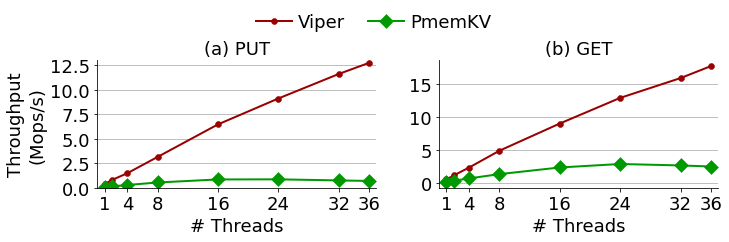

In [18]:
fig, (insert_ax, get_ax) = plt.subplots(1, 2, figsize=(10, 3))


def get_bm_ax(bm_type):
    if bm_type == 'insert': return insert_ax
    if bm_type == 'get': return get_ax
    if bm_type == 'update': return update_ax
    if bm_type == 'delete': return delete_ax
    raise RuntimeError(f"Unknown bm_type {bm_type}")

num_threads = sorted({run['threads'] for run in list(runs.values())[0]})

for bm_type, letter in zip(ALL_BM_TYPES, ['a', 'b', 'c', 'd']):
    ax = get_bm_ax(bm_type)
    ax.set_xlabel("# Threads", fontsize=18)
    ax.set_title(f"({letter}) {bm_type.upper()}", fontsize=18)
    for (fixture, _) in ALL_FIXTURES:
        r = [run['items_per_second'] / MILLION for run in runs[(fixture, bm_type)]]
        style = STYLES[fixture]
        ax.plot(num_threads, r, marker=style.marker, ms=style.marker_size, 
                color=style.color, markeredgewidth=0.5, lw=2)
    x_ticks = np.append(ax.get_xticks(), 36)
    ax.set_xticks([1, 4, 8, 16, 24, 32, 36])
    ax.set_xlim(0, 37)
    ax.grid(axis='y', which='major')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)


insert_ax.set_ylabel("Throughput\n(Mops/s)", fontsize=18)
insert_ax.set_title(f"(a) PUT", fontsize=18)
insert_ax.set_ylim(0, 13)

fig.legend(loc='upper center', labels=[f[1] for f in ALL_FIXTURES], 
           bbox_to_anchor=(0.5, 1.15), ncol=6, frameon=False, fontsize=18,
           columnspacing=1.3, handletextpad=0.3)

plt.tight_layout()
for ax in (insert_ax, get_ax):
    hide_border(ax, True)
fig.savefig('charts/var_size.pdf', bbox_inches='tight')
fig.savefig('charts/var_size.svg', bbox_inches='tight')